# AlexNet

[ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

## 요약
- ILSVRC-2012 Dataset(120만개 train data, 5만개 val data, 15만개 test data)
- Image는 256x256x3이지만 실제 input은 cropped 된 227x227x3(Augmentation)
- Batch_size 128, momentum 0.9, lr=0.0005, 90 epochs
- Weight init : zero-mean Gaussian distribution and std=0.01
- Bias init : 2,4,5의 conv layer와 FC 는 1, 나머지는 0
- 5 Conv Layer, 3 FC Layer, 3 Overlapping max pooling layer, ReLU, Cross-entropy, LRN(Local Response Normalization)
- 2 GPU 사용했지만 우리는 불가하니 1개로만 한다.<br>
(2개로 하면 각각이 다른 종류의 feature를 추출하기 때문에 성능이 더 좋아진다.)
- Translation(그냥 x,y 좌표로 움직이는거) & Horizontal reflections<br>
(256x256 -> 227x227)

연구자들이 해보니까 LRN은 별로 쓸모가 없더라, 그래서 중요하게 다루지 않는다.

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [263]:
def show_image(x, y, idx_to_classname=None, y_pred=None):
    
    x = x[:6, ...]
    y = y[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(5,5))
    #fig.subplots_adjust(hspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(x[i].permute(1,2,0))

        if y_pred is None:
            if idx_to_classname:
                xlabel = "True: {}".format(idx_to_classname[y[i].item()])
            else:
                xlabel = "True: {}".format(y[i])
        else:
            if idx_to_classname:
                xlabel = "True: {}, Pred: {}".format(idx_to_classname(y[i].item()), idx_to_classname(y_pred[i].item()))
            else:
                xlabel = "True: {}, Pred: {}".format(y[i], y_pred[i])
            
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

# Data Pre-processing

### DataLoader
- ILSVRC-2012 Dataset(120만개 train data, 5만개 val data, 15만개 test data)
- Image는 256x256x3이지만 실제 input은 cropped 된 227x227x3(Augmentation)
- Translation(그냥 x,y 좌표로 움직이는거) & Horizontal reflections<br>
(256x256 -> 227x227)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_path = r'D:\data\ILSVRC2012_img_train'
val_path = r'D:\data\ILSVRC2012_img_val'

trainset = ImageFolder(root=train_path, transform=transform)
valset = ImageFolder(root=val_path, transform=transform)

train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
val_loader = DataLoader(valset, batch_size=8, shuffle=False)

In [262]:
print(trainset)
print('='*100)
print(valset)

Dataset ImageFolder
    Number of datapoints: 1281167
    Root location: D:\data\ILSVRC2012_img_train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 50000
    Root location: D:\data\ILSVRC2012_img_val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


Train Image


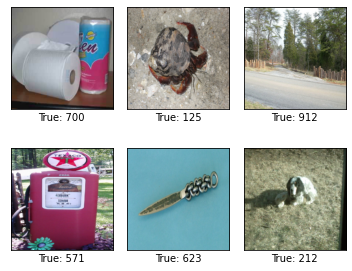

Val Image


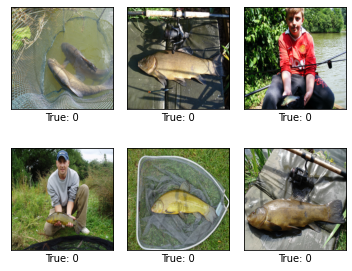

In [264]:
images, labels = iter(train_loader).next()
images_val, labels_val = iter(val_loader).next()

print('Train Image')
show_image(images, labels)
print('='*100)
print('Val Image')
show_image(images_val, labels_val)

### Class name
- map_clsloc.txt : filename $\quad$     n  $\quad$    classname

In [254]:
filename_to_idx = {}
filename_to_classname = {}
idx_to_classname = {}

In [255]:
filename_to_idx = trainset.class_to_idx

len(filename_to_idx)

1000

In [256]:
for r in open(r'D:\data\map_clsloc.txt').readlines():
    
    r_split = r.split(' ') 
    filename_to_classname[r_split[0]] = r_split[2].replace('\n', '')
    
len(filename_to_classname)

1000

In [257]:
for filename, idx in filename_to_idx.items():
    idx_to_classname[idx] = filename_to_classname[filename]

len(idx_to_classname)

1000

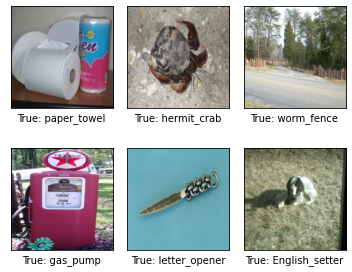

In [265]:
show_image(images, labels, idx_to_classname=idx_to_classname)

# Model Architecture
- Batch_size 128, momentum 0.9, lr=0.0005, 90 epochs
- Weight init : zero-mean Gaussian distribution and std=0.01
- Bias init : 2,4,5의 conv layer와 FC 는 1, 나머지는 0
- 5 Conv Layer, 3 FC Layer, 3 Overlapping max pooling layer, ReLU, Cross-entropy, LRN(Local Response Normalization)
- 2 GPU 사용했지만 우리는 불가하니 1개로만 한다.<br>
(2개로 하면 각각이 다른 종류의 feature를 추출하기 때문에 성능이 더 좋아진다.)